In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Data

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv", index_col=0)
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [3]:
len(train_df)

891

## Explore Data

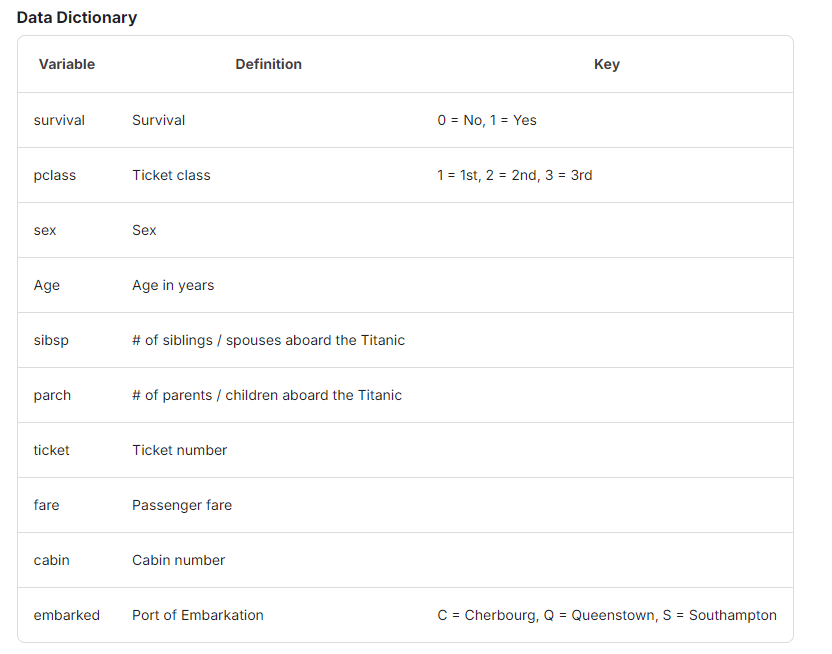

In [4]:
len(train_df)

891

In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
# cabin has 687 nulls, i dont think we can learn anything using it though

In [8]:
# lets check balance now
train_df["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [9]:
class_percentages = train_df["Survived"].value_counts(normalize=True) * 100

print(class_percentages)

threshold = 70  # Adjust this as needed
is_balanced = all(class_percentages < threshold)

if is_balanced:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64
The dataset is balanced.


In [10]:
# so model can easily get 61% accuracy if it always predics 0
# so this will be our basepoint

In [11]:
# check outliers
# Identify outliers for each column
for column in train_df.select_dtypes(include=[np.number]):  # Only numerical columns
    Q1 = train_df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = train_df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Column: {column}")
    print(f"Outliers: {len(train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)][column].tolist())}")

Column: Survived
Outliers: 0
Column: Pclass
Outliers: 0
Column: Age
Outliers: 11
Column: SibSp
Outliers: 46
Column: Parch
Outliers: 213
Column: Fare
Outliers: 116


## Create Dataset Class

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/

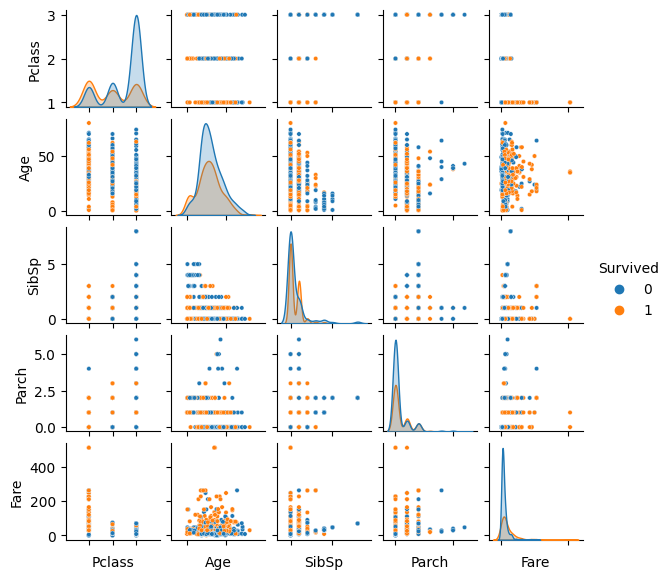

In [12]:
g = sns.pairplot(data=train_df, hue='Survived',
                 size=1.2, diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

<Axes: xlabel='Sex', ylabel='count'>

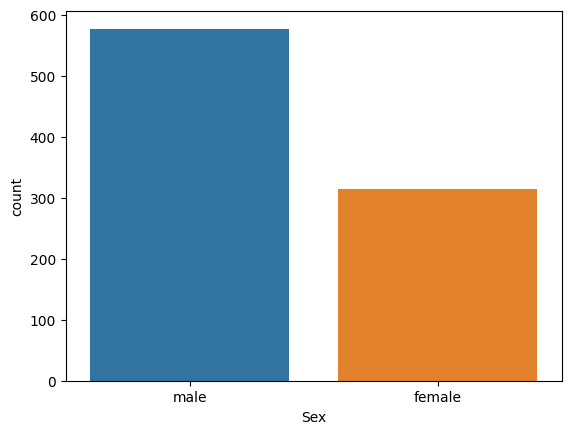

In [13]:
sns.countplot(x='Sex', data=train_df)

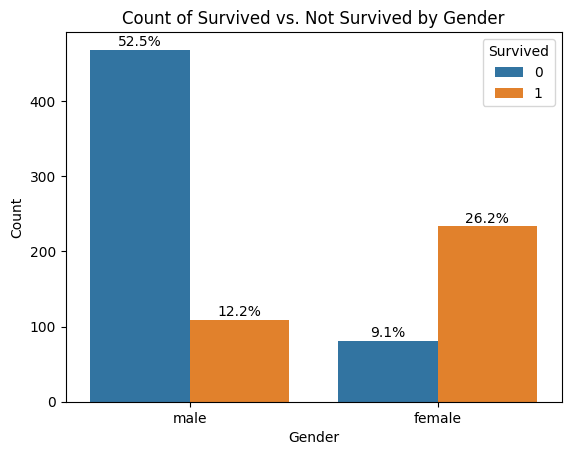

In [14]:
sns.countplot(x='Sex', hue='Survived', data=train_df)

total = len(train_df)

# Add percentage annotations

for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of each bar
    percentage = height / total * 100
    plt.text(x + width / 2, y + height + 5, f'{percentage:.1f}%', ha='center')

plt.title('Count of Survived vs. Not Survived by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Embarked', ylabel='count'>

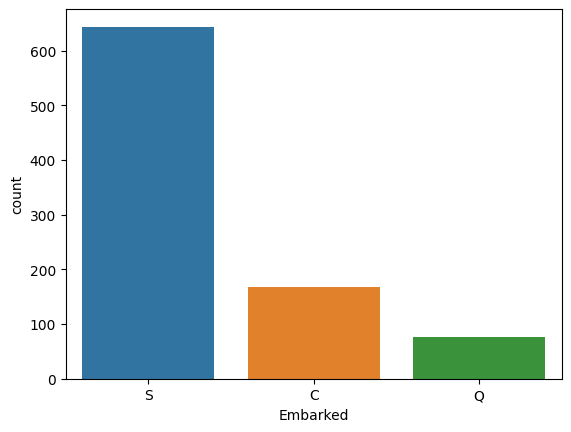

In [15]:
sns.countplot(x='Embarked', data=train_df)

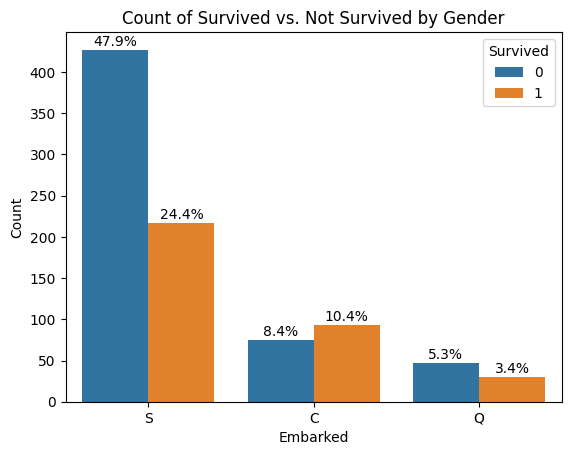

In [16]:
sns.countplot(x='Embarked', hue='Survived', data=train_df)

total = len(train_df)

# Add percentage annotations

for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of each bar
    percentage = height / total * 100
    plt.text(x + width / 2, y + height + 5, f'{percentage:.1f}%', ha='center')

plt.title('Count of Survived vs. Not Survived by Gender')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Pclass', ylabel='count'>

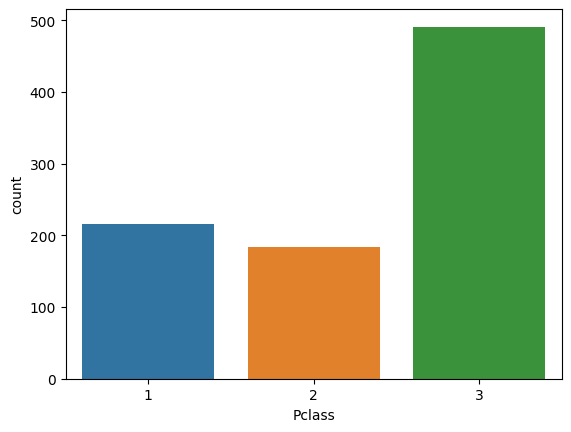

In [17]:
sns.countplot(x='Pclass', data=train_df)

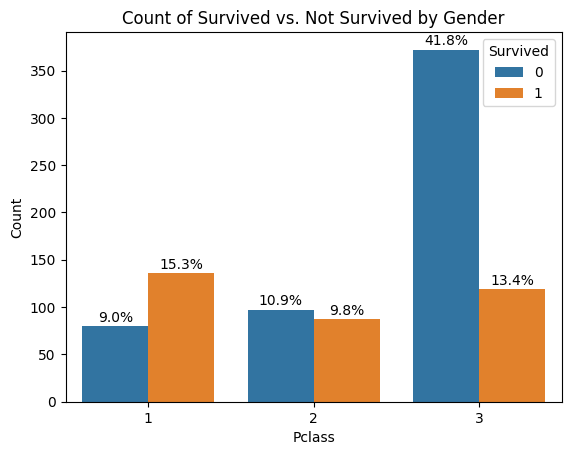

In [18]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)

total = len(train_df)

# Add percentage annotations

for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of each bar
    percentage = height / total * 100
    plt.text(x + width / 2, y + height + 5, f'{percentage:.1f}%', ha='center')

plt.title('Count of Survived vs. Not Survived by Gender')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

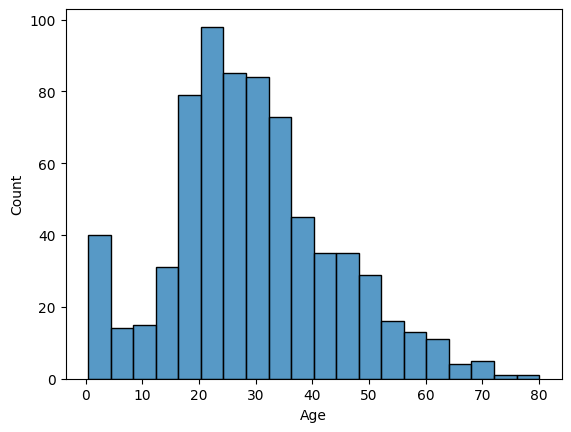

In [19]:
sns.histplot(x='Age', data=train_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


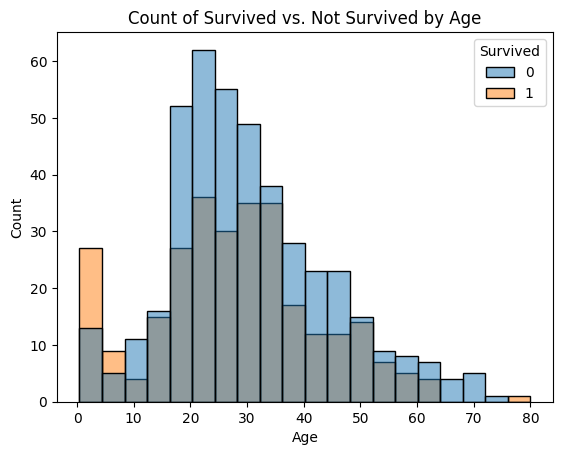

In [20]:
sns.histplot(x='Age', hue='Survived', data=train_df)
plt.title('Count of Survived vs. Not Survived by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SibSp', ylabel='Count'>

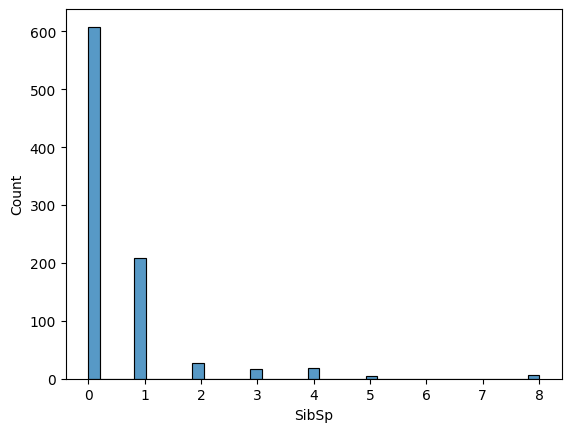

In [21]:
sns.histplot(x='SibSp', data=train_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


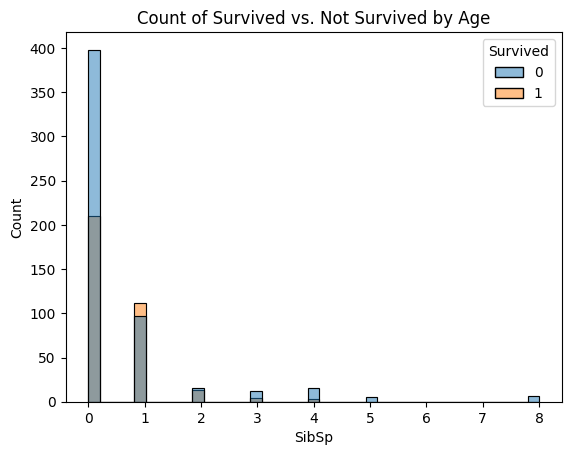

In [22]:
sns.histplot(x='SibSp', hue='Survived', data=train_df)
plt.title('Count of Survived vs. Not Survived by Age')
plt.xlabel('SibSp')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Parch', ylabel='Count'>

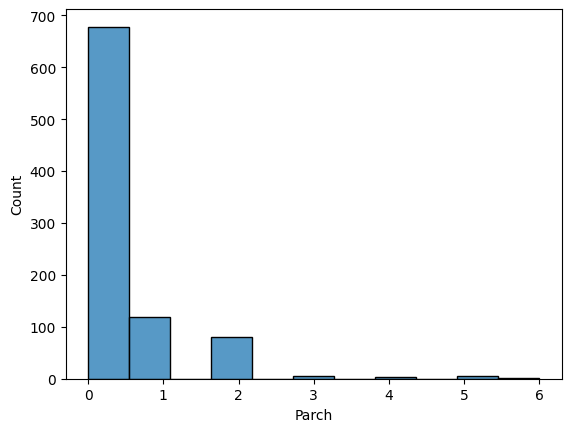

In [23]:
sns.histplot(x='Parch', data=train_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Parch', ylabel='Count'>

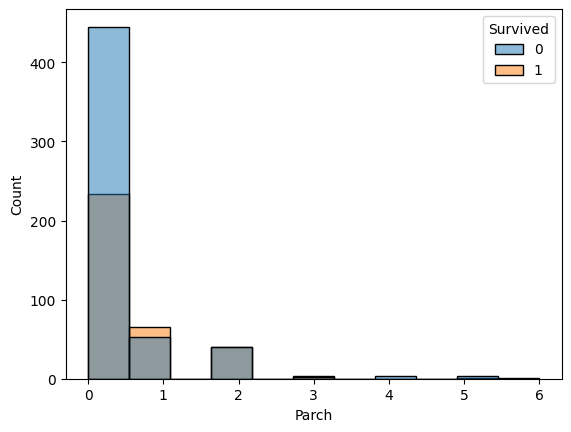

In [24]:
sns.histplot(x='Parch', hue="Survived", data=train_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Fare', ylabel='Count'>

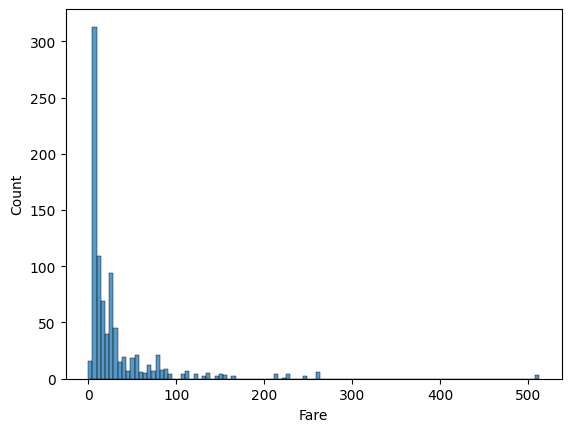

In [25]:
sns.histplot(x='Fare', data=train_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Fare', ylabel='Count'>

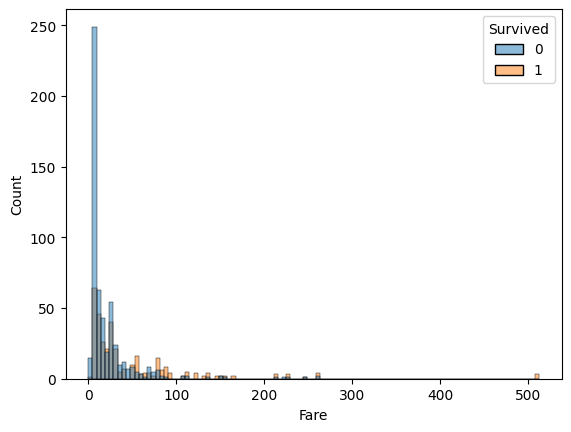

In [26]:
sns.histplot(x='Fare', hue="Survived", data=train_df)

In [27]:
train_df["Family_Name"] = train_df['Name'].str.split(',', expand=True)[0]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Family_Name', ylabel='Count'>

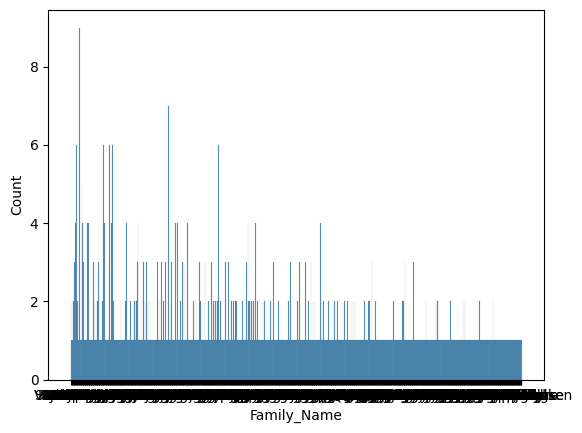

In [28]:
sns.histplot(x='Family_Name', data=train_df)

In [29]:
train_df['Name_Title'] = train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (train_df['Name_Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
train_df['Name_Title'] = train_df['Name_Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Name_Title', ylabel='Count'>

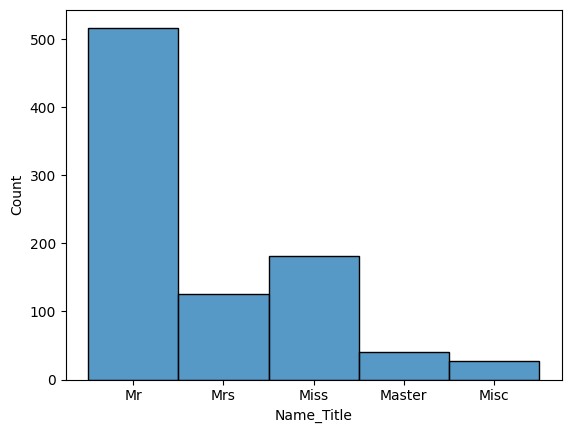

In [30]:
sns.histplot(x='Name_Title', data=train_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Name_Title', ylabel='Count'>

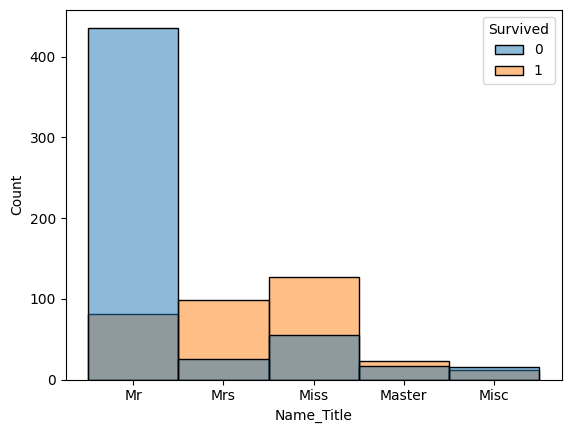

In [31]:
sns.histplot(x='Name_Title', hue="Survived", data=train_df)

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn 
from torch.utils.data import random_split
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [33]:
torch.manual_seed(42); # seed rng for reproducibility

In [34]:
class CSVDataset(Dataset):
    def __init__(self, csv_path, features_col_list, target_col_list, transform=None, entire_data_transform=None, isTest=False):
        # data loading
        self.target_col_list = []
        self.data = pd.read_csv(csv_path, index_col=0)
        
        if (isTest):
            self.data[target_col_list[0]] = 1
        
        self.transform = transform

        self.data = entire_data_transform(self.data)

        self.features_col_list = []
        for col_name in self.data.columns:
            for feature_name in features_col_list:
                if feature_name in col_name:
                    # col is one hot encoded
                    self.features_col_list.append(col_name)

            for feature_name in target_col_list:
                if feature_name in col_name:
                    # col is one hot encoded
                    self.target_col_list.append(col_name)


    def __getitem__(self, index):
        x = self.data.iloc[index][self.features_col_list]  # Features}
        y = self.data.iloc[index][self.target_col_list]  # Target

        # Apply transformations if specified
        if self.transform:
            x, y = self.transform((x,y))

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # allow us to use len(dataset)
        return len(self.data)

In [35]:
class PreprocessCols():
    def __init__(self, col_funcs):
        self.col_funcs = col_funcs

    def __call__(self, dataset):
        for col_func in self.col_funcs:
            if (col_func["col"]=="."):
                col_func["func"](dataset)
                continue

            if ("new_col_name" in col_func.keys()):
                dataset[col_func["new_col_name"]] = dataset[col_func["col"]].apply(col_func["func"])
            else:
                dataset[col_func["col"]] = dataset[col_func["col"]].apply(col_func["func"])
                
        return dataset

class OneHotEncode():
    def __init__(self, cat_cols):
        self.encoder = ColumnTransformer(
            transformers=[
                ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
            ],
            remainder='passthrough'
        )
        self.isFit = False
    
    def __call__(self, dataset):        
        if (self.isFit==False):
            self.isFit = True
            self.encoder.fit(dataset)
            
        encoded_dataset = self.encoder.transform(dataset)
        return pd.DataFrame(encoded_dataset, columns=self.encoder.get_feature_names_out())
        
class FillNa():
    def __init__(self, col_na_fill_rule):
        self.col_na_fill_rule = col_na_fill_rule

    def __call__(self, dataset):
        for col, na_fill in self.col_na_fill_rule.items():
            dataset[col].fillna(na_fill, inplace=True)

        return dataset

class NormalizeCol():
    def __init__(self, cols_min_max_val):
        self.cols_min_max_val = cols_min_max_val
    
    def __call__(self, sample):
        inputs, targets = sample

        for col in self.cols_min_max_val:
            inputs[col] = (inputs[col] - self.cols_min_max_val[col]["minVal"]) / (self.cols_min_max_val[col]["maxVal"] - self.cols_min_max_val[col]["minVal"])
        
        return (inputs, targets)

class ConvertNumpyArrToFloat32Tensor():
    def __call__(self, sample):
        inputs, targets = sample
        inputs = (inputs.values).astype(np.float32)
        targets = (targets.values).astype(np.float32)
        return (inputs, targets)

In [36]:
csv_file = "/kaggle/input/titanic/train.csv"
features_col_list = ["Embarked", "Sex", "Pclass", "Age", "SibSp", "Parch", "Fare", "Cabin_Alphabet", "Cabin_Number", "Name_Title"]
target_col_list = ["Survived"]

cat_cols = ["Embarked", "Sex", "Pclass", "Cabin_Alphabet", "Name_Title"]
fill_na = {"Embarked": "S", "Age": train_df["Age"].median(), "Cabin": "U0"} 
normalize_cols = {"remainder__Age": {"minVal": 0, "maxVal": 150}, "remainder__SibSp": {"minVal": 0, "maxVal": 50}, "remainder__Parch": {"minVal": 0, "maxVal": 50}, "remainder__Fare": {"minVal": 0, "maxVal": 600}, "remainder__Cabin_Number": {"minVal": 0, "maxVal": 500}}    

def createNameTitle(dataset):
    dataset['Name_Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    #cleanup rare title names
    #print(data1['Title'].value_counts())
    stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
    title_names = (dataset['Name_Title'].value_counts() < stat_min) #this will create a true false series with title name as index
    
    #apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
    dataset['Name_Title'] = dataset['Name_Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

    return dataset

def cabinAlphabet(cabin):
    cabin = str(cabin)
    return cabin.split()[0][0]

def cabinNum(cabin):
    num = "0"
    cabin = str(cabin)
    foundNum = False
    for char in cabin:
        if (char.isdigit()):
            foundNum = True
            num = num + char
        else:
            if (foundNum):
                break
    return int(num)
    
preprocess_col = [{"col": "Cabin", "func": cabinAlphabet, "new_col_name": "Cabin_Alphabet"},
                  {"col": "Cabin", "func": cabinNum, "new_col_name": "Cabin_Number"},
                  {"col": ".", "func": createNameTitle, "new_col_name": "."}]

transforms = torchvision.transforms.Compose([NormalizeCol(normalize_cols),
                                             ConvertNumpyArrToFloat32Tensor()])
one_hot_encode_transform = OneHotEncode(cat_cols)
entire_data_transform = torchvision.transforms.Compose([FillNa(fill_na), PreprocessCols(preprocess_col), one_hot_encode_transform])

dataset = CSVDataset(csv_file, features_col_list, target_col_list, transform=transforms, entire_data_transform=entire_data_transform)
dataset[0]

(tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.1467, 0.0200, 0.0000, 0.0121, 0.0000]),
 tensor([0.]))

In [37]:
len(dataset)

891

In [38]:
# Define split ratios
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [39]:
# Define batch size
# since we have less data
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [41]:
debug = True

input_dim = len(next(iter(train_loader))[0][0])
hidden_neuron = 256
output_dim = len(next(iter(train_loader))[1][0])

class LinearLayer(nn.Linear):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class LeakyReluLayer(nn.LeakyReLU):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class BatchNorm1dLayer(nn.BatchNorm1d):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class DropoutLayer(nn.Dropout):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class TitanicSurvivalPredictor(nn.Module):
    def __init__(self, hidden_neuron):
        super().__init__()

        # define layers
        self.layers = nn.ModuleList([
            LinearLayer(input_dim, 128),
            BatchNorm1dLayer(128),
            LeakyReluLayer(),
            DropoutLayer(0.5),
            
            LinearLayer(128, 64),
            BatchNorm1dLayer(64),
            LeakyReluLayer(),
            DropoutLayer(0.5),

            LinearLayer(64, 32),
            BatchNorm1dLayer(32),
            LeakyReluLayer(),
            DropoutLayer(0.5),

            LinearLayer(32, 16),
            BatchNorm1dLayer(16),
            LeakyReluLayer(),
            DropoutLayer(0.5),

            LinearLayer(16, 8),
            BatchNorm1dLayer(8),
            LeakyReluLayer(),
            DropoutLayer(0.5),
                        
            LinearLayer(8, output_dim),
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

model = TitanicSurvivalPredictor(hidden_neuron)

In [42]:
activation_layers = ["LeakyReluLayer"]

In [43]:
@torch.no_grad()
def initParam(model):
    # Initialize weights using Xavier Normal
    for i, layer in enumerate(model.layers):
        if (isinstance(layer, LinearLayer)):
            if (i<len(model.layers)-1):
                nn.init.xavier_normal_(model.layers[i].weight, gain=torch.nn.init.calculate_gain("leaky_relu"))
            else:
                nn.init.xavier_normal_(model.layers[i].weight, gain=torch.nn.init.calculate_gain("sigmoid"))
            if layer.bias is not None:
                nn.init.zeros_(model.layers[i].bias)

initParam(model)

In [44]:
init_loss = 0
model = model.to(device)
bce_loss = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        pred = model(inputs)        
        loss = bce_loss(pred, labels)

        init_loss += loss.item()

init_loss /= len(train_loader)
print(f"init loss: {init_loss}")

init loss: 0.8769974967707759


In [45]:
# less lr rate since can overfit easily
learning_rate = 1e-2
# less epoch as can easily overfit
num_epoch = 10

lossi_train = []
lossi_val = []
metric_val = []
ud = [] # update to data ration

total_samples = len(train_dataset)
n_iter = math.ceil(total_samples / batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
bce_loss = nn.BCEWithLogitsLoss()
output_grads = []

model = model.to(device)

runFirstBatch = False
for epoch in range(num_epoch):
    # reset to train mode
    model.train()
    
    train_loss = 0    
    for i, (inputs, labels) in enumerate(train_loader):
        # reset grad
        optimizer.zero_grad()
        
        # forward pass
        # print(f"inputs: {inputs}")
        # print(f"labels: {labels}")
        inputs = inputs.to(device)
        labels = labels.to(device)

        # print(f"inputs device: {inputs.device}, labels device: {labels.device}, model device: {[param.device for param in model.parameters()]}")
        
        pred = model(inputs)
        # print(f"pred: {pred}")

        # calc loss
        loss = bce_loss(pred, labels)

        if (debug):
            for layer in model.layers:
                layer.output.retain_grad() # save gradients of non leaf tensors also
        
        # backward pass
        loss.backward()
        optimizer.step()
        loss = loss.log10()
        train_loss += loss.item()

    # copied it to array since running with no grad will set grad to None
    if (debug):
        curr_grads = {}
        for i, layer in enumerate(model.layers):
            curr_grads[f"{layer.__class__.__name__}: {i}"] = layer.output.grad.clone()

        output_grads.append(curr_grads)
    
    train_loss /= len(train_loader)
    lossi_train.append(train_loss)

    # validation phase
    model.eval()
    
    # Accuracy calculation
    correct = 0
    total = 0
    accuracy = 0
    val_loss = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        ud.append([((learning_rate*p.grad.std() / p.data.std()).log10().item() if p.ndim == 2 else 0) for p in model.parameters()])
        
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            pred = model(inputs)
            predictions = torch.sigmoid(pred)  # Apply sigmoid for binary classification
            predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)
            
            loss = bce_loss(pred, labels)
            loss = loss.log10()
            val_loss += loss.item()
        
        accuracy = correct / total
        metric_val.append(accuracy)
        val_loss /= len(val_loader)
        lossi_val.append(val_loss)

    if ((epoch+1)%5==0):
        print(f"Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},  Val Metric: {accuracy:.4f}")

        # if (debug):
        #     break

Epoch 5/10, Train Loss: -0.2524, Val Loss: -0.3625,  Val Metric: 0.8539
Epoch 10/10, Train Loss: -0.2921, Val Loss: -0.4035,  Val Metric: 0.8764


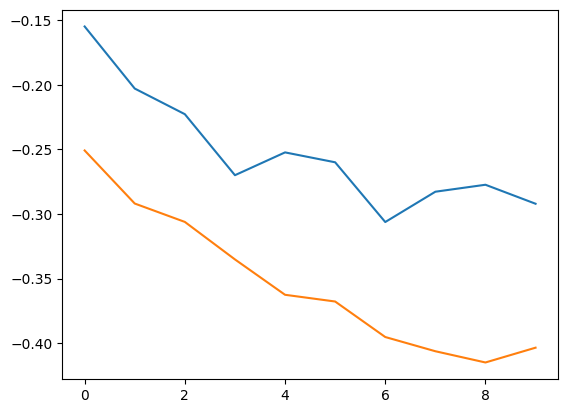

In [46]:
plt.plot(lossi_train)
plt.plot(lossi_val)

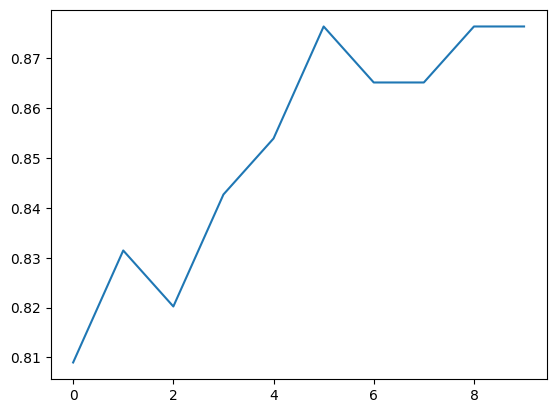

In [47]:
plt.plot(metric_val)

layer 2 (LeakyReluLayer): mean +0.38, std 0.59
layer 6 (LeakyReluLayer): mean +0.32, std 0.56
layer 10 (LeakyReluLayer): mean +0.29, std 0.54
layer 14 (LeakyReluLayer): mean +0.27, std 0.55
layer 18 (LeakyReluLayer): mean +0.35, std 0.50


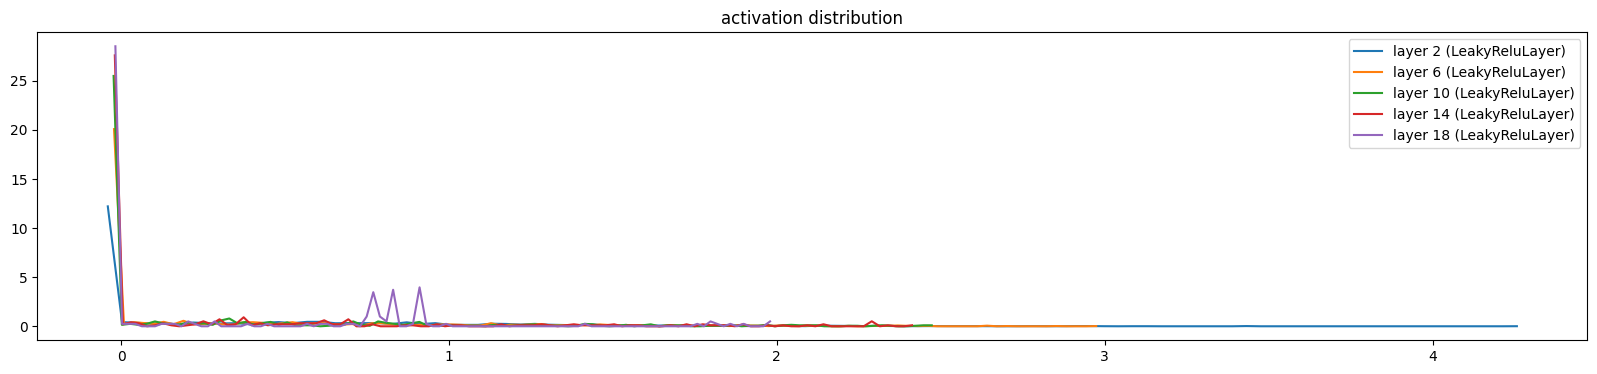

In [48]:
# visualize activations
plt.figure(figsize=(20, 4))
legends = []

if (len(model.layers) > 1):
    for i, layer in enumerate(model.layers): # exclude output layer
        layer_name = layer.__class__.__name__
        for activation_layer in activation_layers:
            if (activation_layer in layer_name):
                t = layer.output.cpu()
                print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'layer {i} ({layer.__class__.__name__})')
    
    plt.legend(legends)
    plt.title("activation distribution")

layer (LeakyReluLayer: 2): mean -0.000037, std 2.980839e-03
layer (LeakyReluLayer: 6): mean -0.000032, std 4.344683e-03
layer (LeakyReluLayer: 10): mean -0.000473, std 7.083998e-03
layer (LeakyReluLayer: 14): mean -0.000347, std 1.259896e-02
layer (LeakyReluLayer: 18): mean +0.003358, std 2.477138e-02


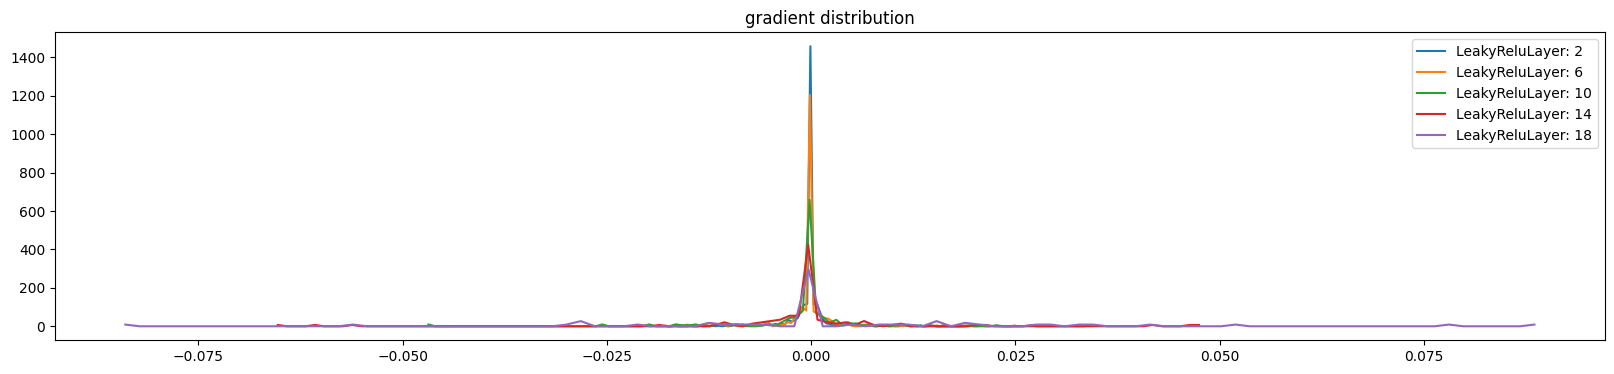

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

if (len(model.layers) > 1):
    for layer_name, layer_grad in output_grads[-1].items(): # note: exclude the output
        for activation_layer in activation_layers:
            if (activation_layer in layer_name):
                t = layer_grad.cpu()
                print('layer (%10s): mean %+f, std %e' % (layer_name, t.mean(), t.std()))
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'{layer_name}')
    
        plt.legend(legends);
        plt.title('gradient distribution')

weight  (128, 27) | mean +0.000010 | std 6.741656e-03 | grad:data ratio 3.407583e-02
weight  (64, 128) | mean +0.000004 | std 4.342130e-03 | grad:data ratio 2.400770e-02
weight   (32, 64) | mean -0.000186 | std 7.172928e-03 | grad:data ratio 3.032135e-02
weight   (16, 32) | mean +0.000268 | std 1.373060e-02 | grad:data ratio 4.365333e-02
weight    (8, 16) | mean +0.001201 | std 2.799624e-02 | grad:data ratio 6.455475e-02
weight     (1, 8) | mean +0.049011 | std 1.385788e-01 | grad:data ratio 3.549048e-01


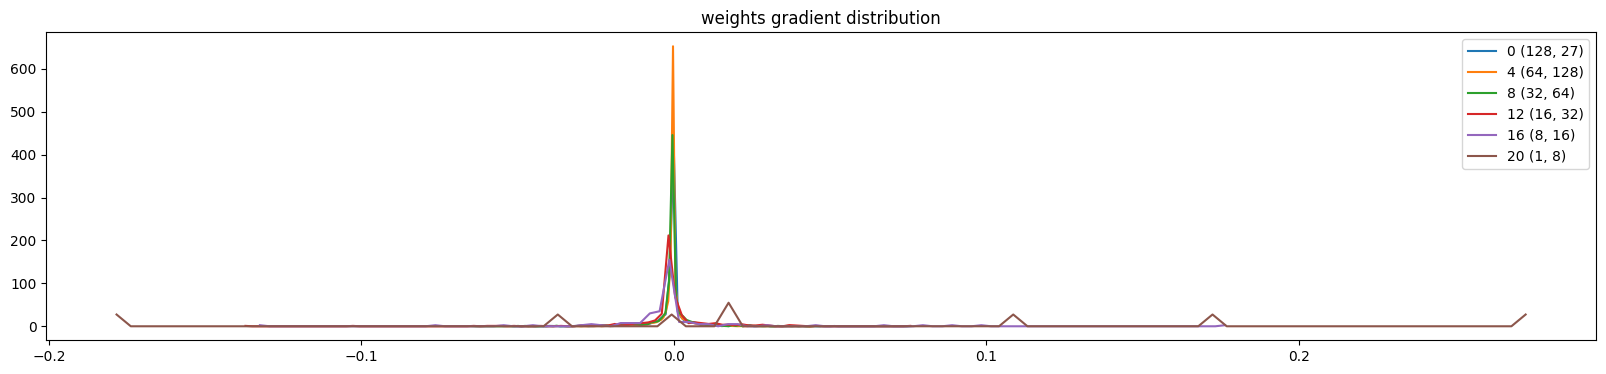

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2: # limit to weights only
    t = p.grad.cpu()
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# gradient to data ratio should be less

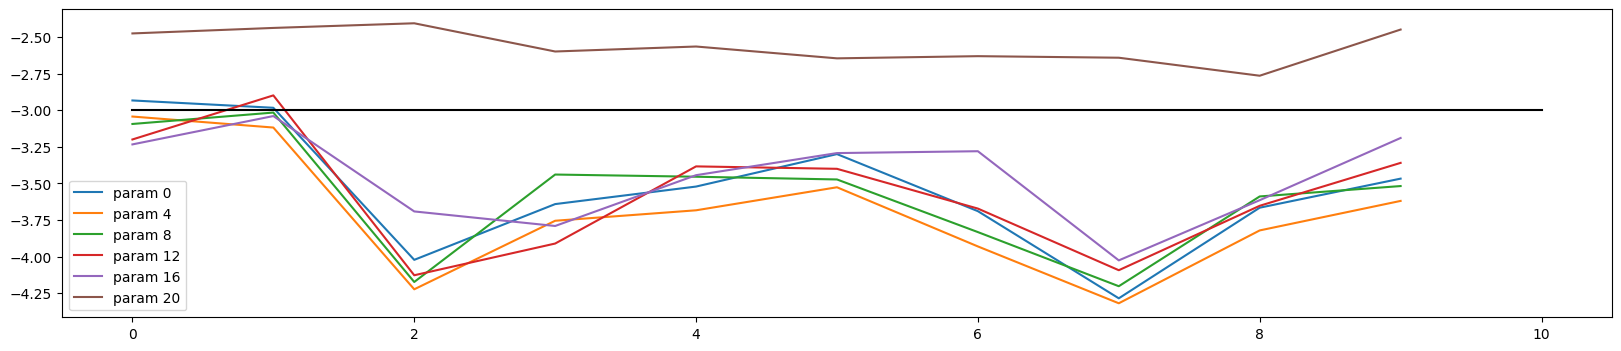

In [51]:
# plot update to data ratio
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
# less than 1e-3 means learning to slow
plt.legend(legends);

In [52]:
model.eval()  # Set model to evaluation mode

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
        correct += (predicted_classes == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 82.22%


In [53]:
model.eval()  # Set model to evaluation mode

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
        correct += (predicted_classes == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 81.46%


## Test

In [54]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [55]:
len(test_df)

418

In [56]:
csv_file = "/kaggle/input/titanic/test.csv"
target_col_list = ["Survived"]

transforms = torchvision.transforms.Compose([NormalizeCol(normalize_cols),
                                             ConvertNumpyArrToFloat32Tensor()])

entire_data_transform = torchvision.transforms.Compose([FillNa(fill_na), PreprocessCols(preprocess_col), one_hot_encode_transform])

final_test_dataset = CSVDataset(csv_file, features_col_list, target_col_list, transform=transforms, entire_data_transform=entire_data_transform, isTest=True)
final_test_dataset[0]

(tensor([0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.2300, 0.0000, 0.0000, 0.0130, 0.0000]),
 tensor([1.]))

In [57]:
len(final_test_dataset)

418

In [58]:
final_test_loader = DataLoader(final_test_dataset, shuffle=False)

pred = []
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in final_test_loader:
        inputs = inputs.to(device)
    
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)

        pred.append(int(predicted_classes.item()))

In [59]:
len(final_test_loader)

418

In [60]:
pred_df = pd.DataFrame(pred, columns=["Survived"])
pred_df["PassengerId"] = test_df["PassengerId"]
pred_df.to_csv("pred.csv", index=False)

In [61]:
pred_df.head()

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,0,896
